In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
import sys
import os

# Importar as funções de processamento de texto
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_processing import preprocess_text, process_tokenize

/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
twitts_train = pd.read_csv("../data/twitter_training.csv")
twitts_valid = pd.read_csv("../data/twitter_validation.csv")

In [3]:
column_name=['tweetID','entity','sentiment','tweet_content']
twitts_train.columns=column_name
twitts_valid.columns=column_name
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# clean the duplicated tweets
twitts_train = twitts_train.drop_duplicates(subset=['tweet_content'])
twitts_valid = twitts_valid.drop_duplicates(subset=['tweet_content'])

# clean the empty tweets
twitts_train = twitts_train.dropna(subset=['tweet_content'])
twitts_valid = twitts_valid.dropna(subset=['tweet_content'])

# lower case the sentiment labels
twitts_train['sentiment'] = twitts_train['sentiment'].str.lower()
twitts_valid['sentiment'] = twitts_valid['sentiment'].str.lower()

# Reset index after cleaning
twitts_train.reset_index(drop=True, inplace=True)
twitts_valid.reset_index(drop=True, inplace=True)

print("Number of tweets in training set after cleaning:", len(twitts_train))
print("Number of tweets in validation set after cleaning:", len(twitts_valid))
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# Remove the irrelevant sentiment label
twitts_train = twitts_train[twitts_train['sentiment'].isin(['positive', 'negative', 'neutral'])]
twitts_valid = twitts_valid[twitts_valid['sentiment'].isin(['positive', 'negative', 'neutral'])]


Number of duplicate tweets in training set: 2700
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 686
Number of nan values in validation set: 0
Number of tweets in training set after cleaning: 69490
Number of tweets in validation set after cleaning: 998
Number of duplicate tweets in training set: 0
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 0
Number of nan values in validation set: 0


In [4]:
twitts_train.drop(columns=['tweetID', 'entity'], inplace=True)
twitts_valid.drop(columns=['tweetID', 'entity'], inplace=True)

In [5]:
data = pd.concat([twitts_train, twitts_valid], ignore_index=True)

x = data.drop('sentiment', axis=1)
y = data.sentiment

# Processar os textos - usando preprocess_text em vez de process_tokenize
texts = list(x['tweet_content'])
print("\n===== APLICANDO PRÉ-PROCESSAMENTO AOS TEXTOS =====\n")
print(f"Processando {len(texts)} tweets...")

# Opção 1: Usar a função preprocess_text que retorna strings
cleaned_text = [preprocess_text(text) for text in texts]

# Verificar exemplos de textos processados
print("\n===== EXEMPLOS DE TEXTOS PROCESSADOS =====\n")
for i in range(3):
    print(f"Texto original: {texts[i]}")
    print(f"Texto processado: {cleaned_text[i]}")
    print("-" * 80)


===== APLICANDO PRÉ-PROCESSAMENTO AOS TEXTOS =====

Processando 58101 tweets...

===== EXEMPLOS DE TEXTOS PROCESSADOS =====

Texto original: I am coming to the borders and I will kill you all,
Texto processado: I am coming to the borders and I will kill you all
--------------------------------------------------------------------------------
Texto original: im getting on borderlands and i will kill you all,
Texto processado: im getting on borderlands and i will kill you all
--------------------------------------------------------------------------------
Texto original: im coming on borderlands and i will murder you all,
Texto processado: im coming on borderlands and i will murder you all
--------------------------------------------------------------------------------

===== EXEMPLOS DE TEXTOS PROCESSADOS =====

Texto original: I am coming to the borders and I will kill you all,
Texto processado: I am coming to the borders and I will kill you all
----------------------------------------

In [6]:
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(y)
label_names = label_encoder.classes_

In [7]:
# Verificando a distribuição das classes
class_distribution = pd.Series(y).value_counts()
print("\n===== DISTRIBUIÇÃO DAS CLASSES =====\n")
print(class_distribution)

# Verificar o mapeamento das classes
print("\n===== MAPEAMENTO DAS CLASSES =====\n")
for i, label in enumerate(label_names):
    print(f"Classe {i}: {label}")

# Verificar o mapeamento do modelo RoBERTa
print("\n===== MAPEAMENTO DAS CLASSES NO ROBERTA =====\n")
print("0: Negativo")
print("1: Neutro")
print("2: Positivo")

# Além disso, vamos verificar se precisamos remapear as classes
model_labels = {0: "negative", 1: "neutral", 2: "positive"}
remap_needed = False

for i, label in enumerate(label_names):
    if label != model_labels[i]:
        remap_needed = True
        break
        
if remap_needed:
    print("\nATENÇÃO: O mapeamento das classes no LabelEncoder é diferente do mapeamento no modelo RoBERTa.")
    print("Será necessário remapear as predições.")
else:
    print("\nO mapeamento das classes está correto. Não é necessário remapear as predições.")


===== DISTRIBUIÇÃO DAS CLASSES =====

sentiment
negative    21432
positive    19342
neutral     17327
Name: count, dtype: int64

===== MAPEAMENTO DAS CLASSES =====

Classe 0: negative
Classe 1: neutral
Classe 2: positive

===== MAPEAMENTO DAS CLASSES NO ROBERTA =====

0: Negativo
1: Neutro
2: Positivo

O mapeamento das classes está correto. Não é necessário remapear as predições.


In [8]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def predict_sentiment(texts):
    preds = []
    for text in texts:
        # Se o texto estiver vazio após o pré-processamento, atribuir uma classe padrão (0)
        if not text or len(text.strip()) == 0:
            preds.append(0)  # Classe padrão para textos vazios
            continue
            
        try:
            # Tokenizar o texto para o modelo
            encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding=True)
            
            # Fazer a inferência
            with torch.no_grad():
                output = model(**encoded_input)
                
            # Converter as logits em probabilidades e obter a classe prevista
            probs = softmax(output.logits.numpy()[0])
            pred = np.argmax(probs)
            preds.append(pred)
            
        except Exception as e:
            print(f"Erro ao processar texto: '{text[:50]}...' - {str(e)}")
            preds.append(0)  # Classe padrão em caso de erro
            
    return preds

# Verificar se há textos vazios após o processamento
empty_texts = sum(1 for text in cleaned_text if not text or len(text.strip()) == 0)
print(f"\nTextos vazios após processamento: {empty_texts} de {len(cleaned_text)}")

# Realizar a predição
print("\nRealizando predição de sentimento...")
y_pred = predict_sentiment(cleaned_text)
print(f"Predições realizadas: {len(y_pred)} tweets")


Textos vazios após processamento: 83 de 58101

Realizando predição de sentimento...
Predições realizadas: 58101 tweets
Predições realizadas: 58101 tweets


In [10]:
# Remapear as predições se necessário
if remap_needed:
    print("\n===== REMAPEANDO AS PREDIÇÕES =====\n")
    # Criar dicionário de mapeamento
    mapping = {}
    for roberta_idx, roberta_label in model_labels.items():
        for encoder_idx, encoder_label in enumerate(label_names):
            if roberta_label == encoder_label:
                mapping[roberta_idx] = encoder_idx
    
    print(f"Mapeamento aplicado: {mapping}")
    
    # Aplicar o mapeamento
    y_pred_original = y_pred.copy()
    y_pred = [mapping.get(pred, pred) for pred in y_pred_original]
    
    print(f"Número de rótulos alterados: {sum(1 for a, b in zip(y_pred_original, y_pred) if a != b)}")

In [11]:
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))


Relatório de Classificação:
              precision    recall  f1-score   support

    negative     0.6791    0.7627    0.7185     21432
     neutral     0.4940    0.3974    0.4405     17327
    positive     0.6615    0.6871    0.6740     19342

    accuracy                         0.6286     58101
   macro avg     0.6115    0.6158    0.6110     58101
weighted avg     0.6180    0.6286    0.6208     58101



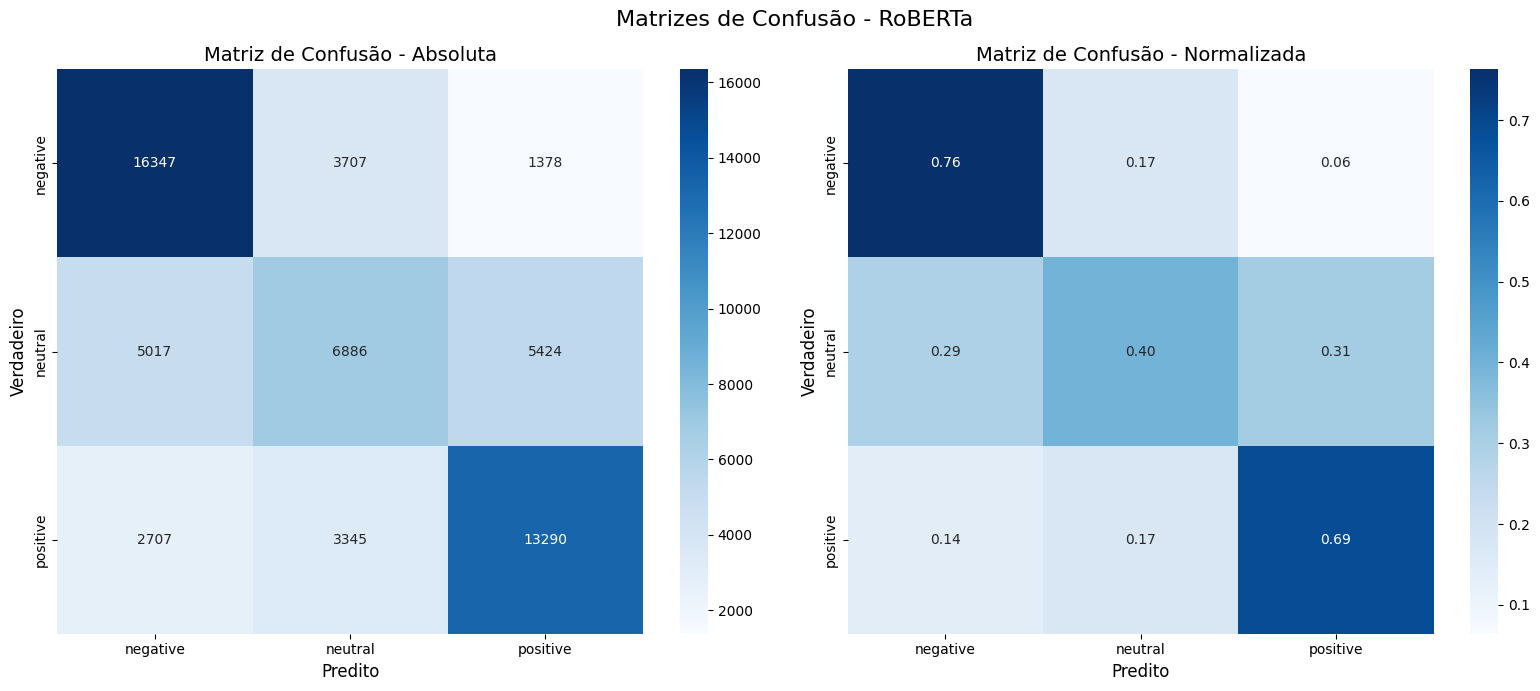


===== MÉTRICAS POR CLASSE =====

Classe: negative
  Precisão: 0.6791
  Recall: 0.7627
  F1-Score: 0.7185
  Amostras: 21432.0

Classe: neutral
  Precisão: 0.4940
  Recall: 0.3974
  F1-Score: 0.4405
  Amostras: 17327.0

Classe: positive
  Precisão: 0.6615
  Recall: 0.6871
  F1-Score: 0.6740
  Amostras: 19342.0



In [12]:
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Criar figura com duas matrizes de confusão
plt.figure(figsize=(16, 7))

# Matriz absoluta
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusão - Absoluta', fontsize=14)
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Verdadeiro', fontsize=12)

# Matriz normalizada
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusão - Normalizada', fontsize=14)
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Verdadeiro', fontsize=12)

plt.suptitle('Matrizes de Confusão - RoBERTa', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Exibir métricas por classe
print("\n===== MÉTRICAS POR CLASSE =====\n")
report = classification_report(y_true, y_pred, target_names=label_names, digits=4, output_dict=True)

# Mostrando detalhes adicionais
for label in label_names:
    metrics = report[label]
    print(f"Classe: {label}")
    print(f"  Precisão: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1-score']:.4f}")
    print(f"  Amostras: {metrics['support']}")
    print()

<Figure size 1000x600 with 0 Axes>

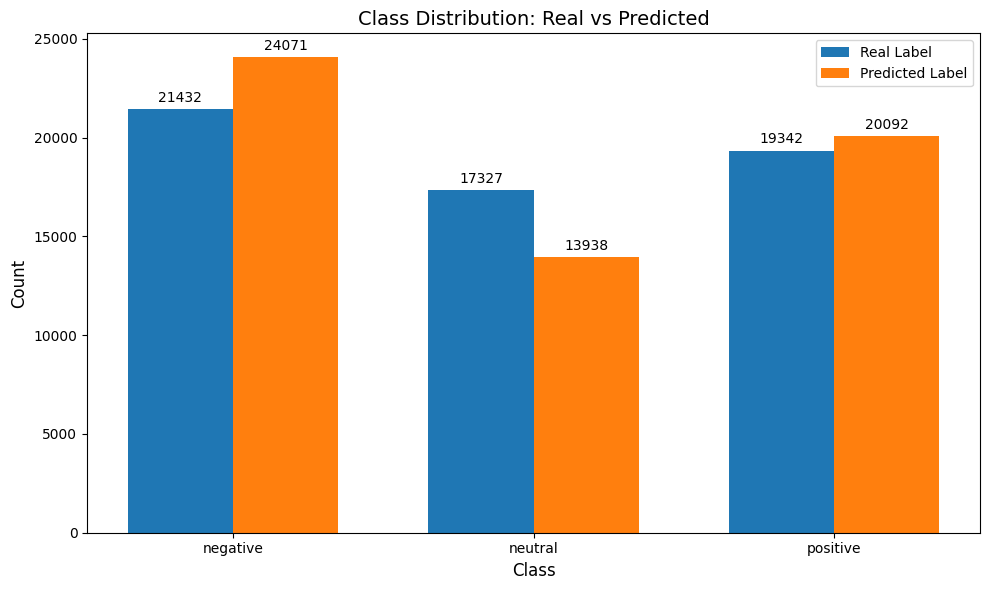

In [15]:
# Visualizar a distribuição das classes reais vs previstas
plt.figure(figsize=(10, 6))

# Preparar dados
df_results = pd.DataFrame({
    'Real': pd.Series(y_true).map(dict(enumerate(label_names))),
    'Previsto': pd.Series(y_pred).map(dict(enumerate(label_names)))
})

# Contar ocorrências
real_counts = df_results['Real'].value_counts().reindex(label_names).fillna(0)
pred_counts = df_results['Previsto'].value_counts().reindex(label_names).fillna(0)

# Plotar gráfico de barras
x = np.arange(len(label_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, real_counts, width, label='Real Label')
bar2 = ax.bar(x + width/2, pred_counts, width, label='Predicted Label')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Class Distribution: Real vs Predicted', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(label_names)
ax.legend()

# Adicionar rótulos nas barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

plt.tight_layout()
plt.show()